In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.9.1
Num GPUs Available:  1


4


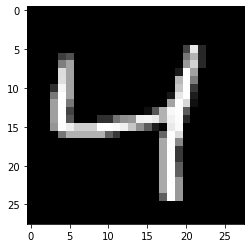

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[2], cmap='gray')

test_image = train_images[2]

train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

print(train_labels[2])

In [59]:
from tensorflow.keras import layers
input_shape = (28, 28, 1)
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(6, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(6, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(10, activation="softmax"),
    ]
)
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=20, validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 6)         60        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 6)         330       
                                                                 
 flatten_7 (Flatten)         (None, 726)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                7270      
                                                                 
Total params: 7,660
Trainable params: 7,660
Non-trainable params: 0
____________________________________________________

C:\Users\flami\miniconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1500/1500 [==============================] - 9s 6ms/step - loss: 0.3050 - accuracy: 0.9114 - val_loss: 0.1362 - val_accuracy: 0.9620
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1115 - accuracy: 0.9657 - val_loss: 0.0906 - val_accuracy: 0.9747
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0834 - accuracy: 0.9751 - val_loss: 0.0837 - val_accuracy: 0.9749
Epoch 4/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0690 - accuracy: 0.9789 - val_loss: 0.0731 - val_accuracy: 0.9783
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0619 - accuracy: 0.9809 - val_loss: 0.0659 - val_accuracy: 0.9806
Epoch 6/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0534 - accuracy: 0.9832 - val_loss: 0.0681 - val_accuracy: 0.9799
Epoch 7/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0491 - accuracy: 0.9849 - val_loss: 0.0624 - val_accuracy: 0.9820
Epo

In [60]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.0588 - accuracy: 0.9844
Test accuracy: 0.9843999743461609


In [61]:
model.summary()
loss, acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("Restored model, loss: {}".format(loss))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 6)         60        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 6)         330       
                                                                 
 flatten_7 (Flatten)         (None, 726)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                7270      
                                                                 
Total params: 7,660
Trainable params: 7,660
Non-trainable params: 0
____________________________________________________

In [67]:
model.save('mnist-tflite')

INFO:tensorflow:Assets written to: mnist-tflite\assets


INFO:tensorflow:Assets written to: mnist-tflite\assets


In [68]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_saved_model('mnist-tflite')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()
tflite_model_size = open('./mnist_model.tflite', "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

Quantized model is 11592 bytes


In [ ]:
# https://www.tensorflow.org/lite/microcontrollers/build_convert
# xxd -i mnist_model.tflite > model_data.cc

# Helpful for Git Bash https://gist.github.com/evanwill/0207876c3243bbb6863e65ec5dc3f058

In [70]:
interpreter = tf.lite.Interpreter(model_path='./mnist_model.tflite')
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: serving_default_input_3:0
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([ 1, 28, 28,  1]), 'shape_signature': array([-1, 28, 28,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

DUMP OUTPUT
{'name': 'StatefulPartitionedCall:0', 'index': 15, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [55]:
import pathlib

tflite_models_dir = pathlib.Path(".")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24608

In [76]:
f= open("../tensorflow-lite-esp32/firmware/src/digit.h","w")
f.write("const float digit[] = { \n")
for d in test_image.flatten():
    f.write(str(d))
    f.write(',')
f.write('\n};')
f.close()